# Rede convolucional para identificação de células de tecido sanguíneo a partir de imagens de microscópio

Fonte de dados: https://data.mendeley.com/datasets/snkd93bnjr/1

Rede Neural Convolucional estudada: **Xception**

Última modificação: 07/08/2021

In [1]:
# Bibliotecas Python necessárias e outras
import os
from google.colab import files
import zipfile
import numpy as np
import pandas as pd
import cv2
# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
# Sklearn
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, classification_report

import tensorflow as tf
# Keras
import keras
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Sequential, Model 
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.data_utils import get_file

## Leitura dos dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Criação de um diretório "dataset", o zip é colocado nesse dataset
os.makedirs("/content/dataset_zip/", exist_ok=True)

In [14]:
!cp /content/drive/MyDrive/TCC2020/blood/dados_bood/dataset_zip.zip /content/

In [ ]:
!unzip /content/dataset_zip.zip

In [16]:
# TESTAR
!mv /content/train /content/dataset_zip/
!mv /content/test /content/dataset_zip/

In [17]:
# Diretorio com imagens de treino de eosinofilo
train1 = os.path.join('/content/dataset_zip/train/EOSINOPHIL')
# Diretorio com imagens de teste de EOSINOPHIL 
test1 = os.path.join('/content/dataset_zip/test/EOSINOPHIL')

# Diretorio com imagens de treino de linfocito
train2 = os.path.join('/content/dataset_zip/train/LYMPHOCYTE')
# Diretorio com imagens de teste de linfocito 
test2 = os.path.join('/content/dataset_zip/test/LYMPHOCYTE')

# Diretorio com imagens de treino de monocito
train3 = os.path.join('/content/dataset_zip/train/MONOCYTE')
# Diretorio com imagens de teste de monocito 
test3 = os.path.join('/content/dataset_zip/test/MONOCYTE')

# Diretorio com imagens de treino de neutrofilo
train4 = os.path.join('/content/dataset_zip/train/NEUTROPHIL')
# Diretorio com imagens de teste de neutrofilo 
test4 = os.path.join('/content/dataset_zip/test/NEUTROPHIL')

# Diretorio com imagens de treino de basofilos
train5 = os.path.join('/content/dataset_zip/train/BASOPHIL')
# Diretorio com imagens de teste de neutrofilo 
test5 = os.path.join('/content/dataset_zip/test/BASOPHIL')



print('total train eosinofilo:', len(os.listdir(train1)))
print('total test eosinofilo:', len(os.listdir(test1)))


print('total train linfocito:', len(os.listdir(train2)))
print('total test linfocito:', len(os.listdir(test2)))

print('total train monocito:', len(os.listdir(train3)))
print('total test monocito:', len(os.listdir(test3)))

print('total train neutrofilo:', len(os.listdir(train4)))
print('total test neutrofilo:', len(os.listdir(test4)))


print('total train basofilo:', len(os.listdir(train5)))
print('total test basofilo:', len(os.listdir(test5)))

total train eosinofilo: 2493
total test eosinofilo: 624
total train linfocito: 971
total test linfocito: 243
total train monocito: 1136
total test monocito: 284
total train neutrofilo: 2663
total test neutrofilo: 666
total train basofilo: 974
total test basofilo: 244


## Pré-processamento dos dados

In [ ]:
IMAGE_SIZE = (150,150)
TRAIN_DIR = '/content/dataset_zip/train'
TEST_DIR = '/content/dataset_zip/test'
BATCH_SIZE = 32

In [ ]:
# Criação dos geradores
# Separando os dados de treino (80% treino e 20% validação)
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

In [ ]:
# Gerar lotes de dados
'''
Return:
Uma tupla DirectoryIterator produtiva de (x, y) onde x é uma matriz numpy contendo um lote
de imagens com forma (batch_size, *target_size, channels) e y uma matriz numpy
de rótulos correspondentes.
'''
train_images = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42
)

Found 6592 images belonging to 5 classes.
Found 1645 images belonging to 5 classes.
Found 2061 images belonging to 5 classes.


## Xception com *Transfer Learning*
Baseado na documentação do keras: https://keras.io/guides/transfer_learning/#the-typical-transferlearning-workflow

In [ ]:
# Instanciando um modelo básico com pesos pré-treinados
base_model = Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
    pooling='avg')

base_model.trainable = False

In [ ]:
# Criação de um novo modelo 
inputs = base_model.input
x = Dense(128, activation='relu')(base_model.output) # Adicionando mais uma camada Dense
outputs = Dense(5, activation='softmax')(x) # Camada de saida

base_model = tf.keras.Model(inputs = inputs, outputs = outputs)

In [ ]:
# Compilando o modelo
base_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 21,124,397
Trainable params: 262,917
Non-trainable params: 20,861,480
__________________________________________________________________________________________________


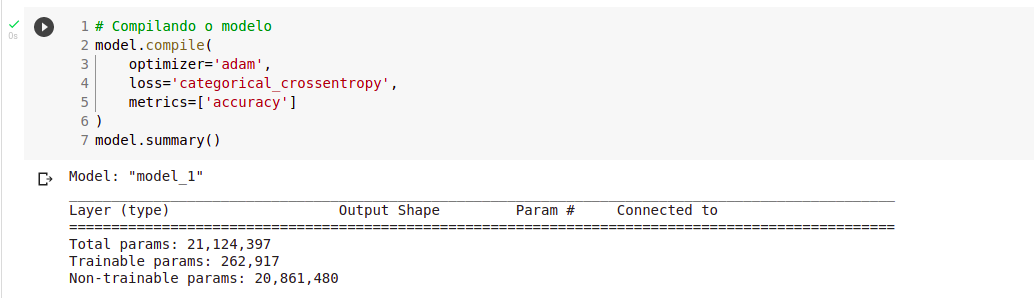

In [ ]:
# Treino do modelo
%%time
history_base = base_model.fit(
    train_images,
    epochs=100,
    steps_per_epoch=train_images.samples // train_images.batch_size,
    validation_steps=val_images.samples // val_images.batch_size,
    validation_data=val_images)

Epoch 1/100


### Visualização Accuracy / Loss

In [ ]:
plt.figure(figsize=(8, 8))
loss_train = history_base.history['accuracy']
loss_val = history_base.history['val_accuracy']
epochs = range(0,100)
plt.plot(epochs, loss_train, 'b', label='Acurácia de treino')
plt.plot(epochs, loss_val, 'g', label='Acurácia de validação')
plt.title('Acurácia de treino e validação')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Try
pd.DataFrame(history_base.history).plot(figsize=(8,8))
plt.grid()
plt.show()

In [ ]:
# Avaliação dp desempenh da CNN
def plotAccucaria(history):
    epochs = [i for i in range(100)]
    fig , ax = plt.subplots(1,2)
    train_acc = history_base.history['accuracy']
    train_loss = history_base.history['loss']
    val_acc = history_base.history['val_accuracy']
    val_loss = history_base.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'b-' , label = 'Acurácia de treinamento')
    ax[0].plot(epochs , val_acc , 'g-' , label = 'Acurária de validação')
    ax[0].set_title('Acurácia de treinamento e validação')
    ax[0].legend()
    ax[0].set_xlabel("Épocas")
    ax[0].set_ylabel("Acurácia")
    ax[0].grid()
    ax[1].grid()
    ax[1].plot(epochs , train_loss , 'b.-' , label = 'Perda no treinamento')
    ax[1].plot(epochs , val_loss , 'r.-' , label = 'Perda na validação')
    ax[1].set_title('Perdas no treinamento e validação')
    ax[1].legend()
    ax[1].set_xlabel("Épocas")
    ax[1].set_ylabel("Perdas")
    
    plt.show()

In [ ]:
# Usando a função plotAcuracia
plotAccucaria(history)

### Resultados - Com *Transfer Learning*

In [ ]:
# Evaluate
score = base_model.evaluate(test_images)

In [ ]:
print("Perda do modelo = ", score[0] * 100, "%")
print("Acurácia do modelo = ", score[1] *100, "%")

In [ ]:
# Salvando o modelo
base_model.save("content/xception_TL_epochs100_acc9315.hdf5")

In [ ]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

In [ ]:
predictions = np.argmax(base_model.predict(test_images, verbose=1, steps=65), axis=1)
acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False, linecolor = 'black', linewidth = 1)
plt.xticks(ticks= np.arange(5) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(5) + 0.5, labels=CLASS_NAMES)

plt.xlabel("Classes previstas")
plt.ylabel("Classes reais")

plt.title("Matriz de confusão")
plt.show()

print("Relatório de classificação:\n----------------------\n", clr)

In [ ]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

## Xception Model

In [ ]:
from keras.models import Model
from keras import layers
from keras.layers import Dense, Input, BatchNormalization, Activation
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils.data_utils import get_file

In [ ]:
def Xception():

	img_input = Input(shape=(150,150,3))

	# Block 1
	x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = Conv2D(64, (3, 3), use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 2
	x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	# Block 2 Pool
	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 3
	x = Activation('relu')(x)
	x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	# Block 3 Pool
	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 4
	x = Activation('relu')(x)
	x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	# Block 5 - 12
	for i in range(8):
		residual = x

		x = Activation('relu')(x)
		x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
		x = BatchNormalization()(x)
		x = Activation('relu')(x)
		x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
		x = BatchNormalization()(x)
		x = Activation('relu')(x)
		x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
		x = BatchNormalization()(x)

		x = layers.add([x, residual])

	residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 13
	x = Activation('relu')(x)
	x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	# Block 13 Pool
	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	# Block 14
	x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	# Block 14 part 2
	x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	# Fully Connected Layer
	x = GlobalAveragePooling2D()(x)
	x = Dense(5, activation='softmax')(x)

	inputs = img_input

	# Create model
	model = Model(inputs, x, name='xception')

	# Download and cache the Xception weights file
	# weights_path = get_file('xception_weights.h5', WEIGHTS_PATH, cache_subdir='models')

	# load weights
	# model.load_weights(weights_path)

	return model

In [ ]:
# Instanciando o modelo
model = Xception()

In [ ]:
%%time
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

# Callback
checkpoint = ModelCheckpoint(filepath='/content/model_propose_20210807_epochs20.hdf5', save_best_only=True, save_weights_only=False)
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 74, 74, 32)   128         conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_70 (Activation)      (None, 74, 74, 32)   0           batch_normalization_80[0][0]     
___________________________________________________________________________________________

In [ ]:
# Treinamento
%%time
history = model.fit(
    train_images,
    steps_per_epoch=train_images.samples // train_images.batch_size,
    epochs=100,
    validation_data=val_images,
    validation_steps=val_images.samples // val_images.batch_size
    )

Epoch 1/100
206/206 [==============================] - 52s 215ms/step - loss: 0.4075 - accuracy: 0.8480 - val_loss: 2.0249 - val_accuracy: 0.1183
Epoch 2/100
206/206 [==============================] - 42s 204ms/step - loss: 0.1100 - accuracy: 0.9683 - val_loss: 4.5353 - val_accuracy: 0.1385
Epoch 3/100
206/206 [==============================] - 42s 204ms/step - loss: 0.0555 - accuracy: 0.9831 - val_loss: 1.2678 - val_accuracy: 0.8554
Epoch 4/100
206/206 [==============================] - 42s 204ms/step - loss: 0.0651 - accuracy: 0.9803 - val_loss: 12.4391 - val_accuracy: 0.3088
Epoch 5/100
206/206 [==============================] - 42s 204ms/step - loss: 0.0400 - accuracy: 0.9879 - val_loss: 13.9376 - val_accuracy: 0.2175
Epoch 6/100
206/206 [==============================] - 42s 204ms/step - loss: 0.0842 - accuracy: 0.9742 - val_loss: 1.5383 - val_accuracy: 0.8051
Epoch 7/100
206/206 [==============================] - 42s 204ms/step - loss: 0.0441 - accuracy: 0.9825 - val_loss: 0.3790

### Visualização Accuracy / Loss (Arquitetura Proposta)

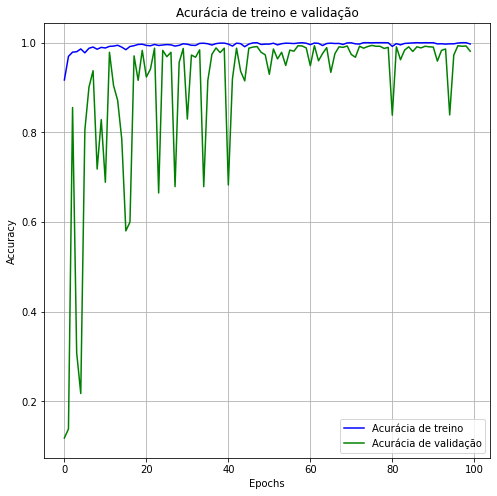

In [ ]:
plt.figure(figsize=(8, 8))
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,100)
plt.plot(epochs, loss_train, 'b', label='Acurácia de treino')
plt.plot(epochs, loss_val, 'g', label='Acurácia de validação')
plt.title('Acurácia de treino e validação')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

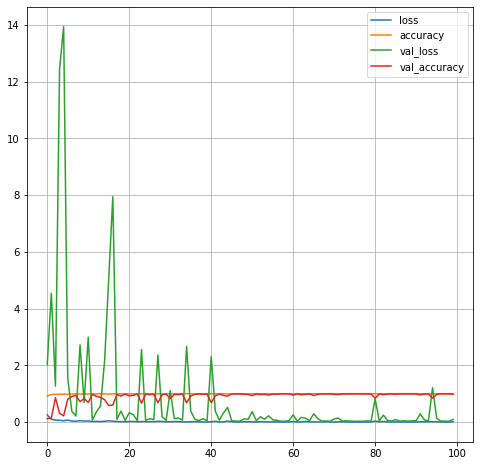

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,8))
plt.grid()
plt.show()

In [ ]:
# Avaliação dp desempenh da CNN
def plotAccucaria(history):
    epochs = [i for i in range(100)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'b-' , label = 'Acurácia de treinamento')
    ax[0].plot(epochs , val_acc , 'g-' , label = 'Acurária de validação')
    ax[0].set_title('Acurácia de treinamento e validação')
    ax[0].legend()
    ax[0].set_xlabel("Épocas")
    ax[0].set_ylabel("Acurácia")
    ax[0].grid()
    ax[1].grid()
    ax[1].plot(epochs , train_loss , 'b.-' , label = 'Perda no treinamento')
    ax[1].plot(epochs , val_loss , 'r.-' , label = 'Perda na validação')
    ax[1].set_title('Perdas no treinamento e validação')
    ax[1].legend()
    ax[1].set_xlabel("Épocas")
    ax[1].set_ylabel("Perdas")
    
    plt.show()

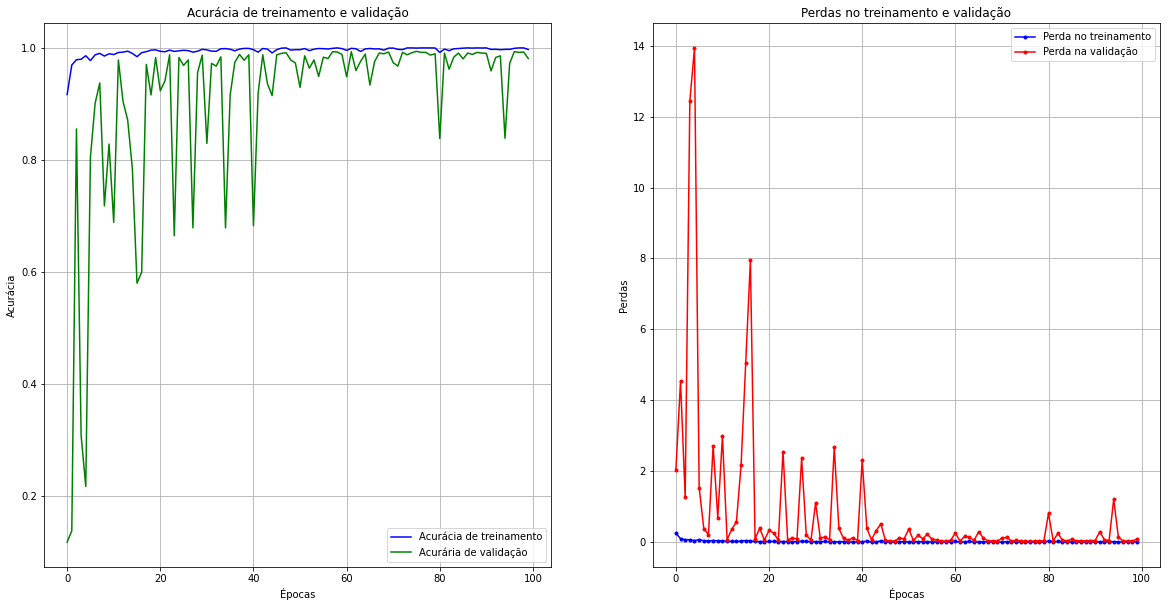

In [ ]:
# Usando a função plotAcuracia
plotAccucaria(history)

### Resultados - Arquitetura Xception poposta

In [ ]:
# Evaluate
score = model.evaluate(test_images, verbose=1, steps=52)
print("Perda do modelo = ", score[0] * 100, "%")
print("Acurácia do modelo = ", score[1] *100, "%")

52/52 [==============================] - 4s 72ms/step - loss: 0.1661 - accuracy: 0.9720


In [ ]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

['BASOPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [ ]:
predictions = np.argmax(model.predict(test_images, verbose=1, steps=65), axis=1)
acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

65/65 [==============================] - 4s 70ms/step
Test Accuracy: 13.052%


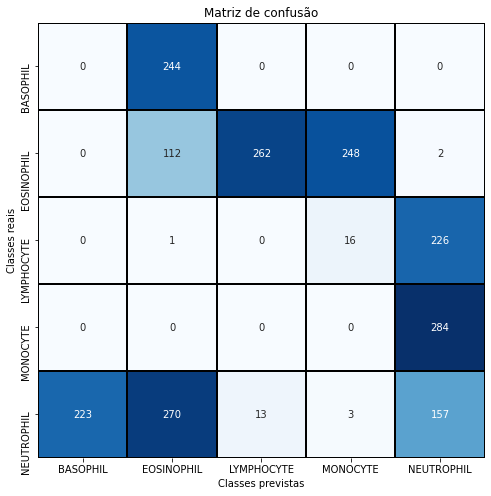

Relatório de classificação:
----------------------
               precision    recall  f1-score   support

    BASOPHIL       0.00      0.00      0.00       244
  EOSINOPHIL       0.18      0.18      0.18       624
  LYMPHOCYTE       0.00      0.00      0.00       243
    MONOCYTE       0.00      0.00      0.00       284
  NEUTROPHIL       0.23      0.24      0.24       666

    accuracy                           0.13      2061
   macro avg       0.08      0.08      0.08      2061
weighted avg       0.13      0.13      0.13      2061



In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False, linecolor = 'black', linewidth = 1)
plt.xticks(ticks= np.arange(5) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(5) + 0.5, labels=CLASS_NAMES)

plt.xlabel("Classes previstas")
plt.ylabel("Classes reais")

plt.title("Matriz de confusão")
plt.show()

print("Relatório de classificação:\n----------------------\n", clr)

# Ambiente Computacional Utilizado
Com o Colab Pro, você tem prioridade no acesso a nossas GPUs mais rápidas. Por exemplo, algumas vezes você terá GPUs T4 ou P100, quando a maioria dos usuários do Colab recebem uma GPU K80, mais lenta. É possível ver qual é a GPU atribuída a qualquer momento, executando a célula a seguir.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Aug  7 20:51:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |   7709MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# É possível ver quanta memória há disponível a qualquer momento, executando o seguinte código.
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
